## Julia in Data Modeling and Exploration

In [1]:
using CSVFiles # loading/saving csv
using DataFrames
using DataFramesMeta
using Dates
using RCall
using PyCall
using VegaDatasets
using Statistics
using DataVoyager
using VegaDatasets
ENV["COLUMNS"]=1000; # for dataframe column size

In [2]:
top5(x::DataFrame) = first(x,5)
last5(x::DataFrame) = last(x,5)

last5 (generic function with 1 method)

Let's use the `cars` dataset from VegaDatasets for modeling 

In [3]:
cars = dataset("cars") |> DataFrame
cars |> top5

,Name,Miles_per_Gallon,Cylinders,Displacement,Horsepower,Weight_in_lbs,Acceleration,Year,Origin
,String,Float64?,Int64,Float64,Int64?,Int64,Float64,String,String
1,chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,1970-01-01,USA
2,buick skylark 320,15.0,8,350.0,165,3693,11.5,1970-01-01,USA
3,plymouth satellite,18.0,8,318.0,150,3436,11.0,1970-01-01,USA
4,amc rebel sst,16.0,8,304.0,150,3433,12.0,1970-01-01,USA
5,ford torino,17.0,8,302.0,140,3449,10.5,1970-01-01,USA


## Data Voyager

Let's feed the `cars` dataset to the Voyager visualization tool and perform some exploratory visualization.

Note: This won't work in remote notebooks.

In [4]:
# cars |> Voyager()

## Julia SQL-like data processing workflow

## High-level queries to manipulate data

### Filter rows

In [5]:
@linq cars |> 
   where(:Origin .== "USA") |> 
   top5

,Name,Miles_per_Gallon,Cylinders,Displacement,Horsepower,Weight_in_lbs,Acceleration,Year,Origin
,String,Float64?,Int64,Float64,Int64?,Int64,Float64,String,String
1,chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,1970-01-01,USA
2,buick skylark 320,15.0,8,350.0,165,3693,11.5,1970-01-01,USA
3,plymouth satellite,18.0,8,318.0,150,3436,11.0,1970-01-01,USA
4,amc rebel sst,16.0,8,304.0,150,3433,12.0,1970-01-01,USA
5,ford torino,17.0,8,302.0,140,3449,10.5,1970-01-01,USA


In [6]:
@subset(cars,:Origin .== "USA") |> last5

,Name,Miles_per_Gallon,Cylinders,Displacement,Horsepower,Weight_in_lbs,Acceleration,Year,Origin
,String,Float64?,Int64,Float64,Int64?,Int64,Float64,String,String
1,chevrolet camaro,27.0,4,151.0,90,2950,17.3,1982-01-01,USA
2,ford mustang gl,27.0,4,140.0,86,2790,15.6,1982-01-01,USA
3,dodge rampage,32.0,4,135.0,84,2295,11.6,1982-01-01,USA
4,ford ranger,28.0,4,120.0,79,2625,18.6,1982-01-01,USA
5,chevy s-10,31.0,4,119.0,82,2720,19.4,1982-01-01,USA


### Filter rows and columns

In [7]:
@linq cars |> 
      where(:Origin .== "Europe") |> # filter rows
      select(:Name,:Year) |>         # subset of columns
      top5

,Name,Year
,String,String
1,citroen ds-21 pallas,1970-01-01
2,volkswagen 1131 deluxe sedan,1970-01-01
3,peugeot 504,1970-01-01
4,audi 100 ls,1970-01-01
5,saab 99e,1970-01-01


### Grouping, Aggregation, and Sorting

In [8]:
mymean(x)=mean(skipmissing(x))

mymean (generic function with 1 method)

In [9]:
@linq cars |> 
      by(:Origin,
          meanAcc = mymean(:Acceleration),
          meanDisp = mymean(:Displacement),
          meanMPG=mymean(:Miles_per_Gallon)
      ) 

┌ Warning: Using an un-quoted Symbol on the LHS is deprecated. Write :meanAcc = ... instead.
└ @ DataFramesMeta /Users/ppalmes/.julia/packages/DataFramesMeta/yzaoq/src/parsing.jl:298
┌ Warning: Using an un-quoted Symbol on the LHS is deprecated. Write :meanDisp = ... instead.
└ @ DataFramesMeta /Users/ppalmes/.julia/packages/DataFramesMeta/yzaoq/src/parsing.jl:298
┌ Warning: Using an un-quoted Symbol on the LHS is deprecated. Write :meanMPG = ... instead.
└ @ DataFramesMeta /Users/ppalmes/.julia/packages/DataFramesMeta/yzaoq/src/parsing.jl:298


,Origin,meanAcc,meanDisp,meanMPG
,String,Float64,Float64,Float64
1,USA,14.9425,247.935,20.0835
2,Europe,16.8219,109.466,27.8914
3,Japan,16.1722,102.709,30.4506


In [10]:
region_stats = @linq  cars |>
                      by([:Origin,:Cylinders],
                          MeanAcceleration=mymean(:Acceleration),
                          MeanHorsepower=mymean(:Horsepower)) |>
                      orderby(:Origin,:Cylinders)

┌ Warning: Using an un-quoted Symbol on the LHS is deprecated. Write :MeanAcceleration = ... instead.
└ @ DataFramesMeta /Users/ppalmes/.julia/packages/DataFramesMeta/yzaoq/src/parsing.jl:298
┌ Warning: Using an un-quoted Symbol on the LHS is deprecated. Write :MeanHorsepower = ... instead.
└ @ DataFramesMeta /Users/ppalmes/.julia/packages/DataFramesMeta/yzaoq/src/parsing.jl:298


,Origin,Cylinders,MeanAcceleration,MeanHorsepower
,String,Int64,Float64,Float64
1,Europe,4,16.7636,78.9062
2,Europe,5,18.6333,82.3333
3,Europe,6,16.425,113.5
4,Japan,3,13.25,99.25
5,Japan,4,16.5696,75.5797
6,Japan,6,13.55,115.833
7,USA,4,16.5264,80.9565
8,USA,6,16.4743,99.6712
9,USA,8,12.837,158.454


In [11]:
res=combine(groupby(cars,[:Origin,:Cylinders])) do x
    macc=mymean(x.Acceleration)
    mincy=mymean(x.Horsepower)
    DataFrame(MeanAcceleration=macc,MeanHorsepower=mincy)
end

,Origin,Cylinders,MeanAcceleration,MeanHorsepower
,String,Int64,Float64,Float64
1,USA,8,12.837,158.454
2,Europe,4,16.7636,78.9062
3,Japan,4,16.5696,75.5797
4,USA,6,16.4743,99.6712
5,USA,4,16.5264,80.9565
6,Japan,3,13.25,99.25
7,Japan,6,13.55,115.833
8,Europe,6,16.425,113.5
9,Europe,5,18.6333,82.3333


In [12]:
sort!(res,[:Origin,:Cylinders])

,Origin,Cylinders,MeanAcceleration,MeanHorsepower
,String,Int64,Float64,Float64
1,Europe,4,16.7636,78.9062
2,Europe,5,18.6333,82.3333
3,Europe,6,16.425,113.5
4,Japan,3,13.25,99.25
5,Japan,4,16.5696,75.5797
6,Japan,6,13.55,115.833
7,USA,4,16.5264,80.9565
8,USA,6,16.4743,99.6712
9,USA,8,12.837,158.454


## R SQL-like data processing workflow

In [13]:
R"""
library(tidyverse)
library(ggplot2)
"""

┌ Warning: RCall.jl: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
│ ✔ ggplot2 3.3.2     ✔ purrr   0.3.4
│ ✔ tibble  3.0.4     ✔ dplyr   1.0.2
│ ✔ tidyr   1.1.2     ✔ stringr 1.4.0
│ ✔ readr   1.4.0     ✔ forcats 0.5.0
│ ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
│ ✖ dplyr::filter() masks stats::filter()
│ ✖ dplyr::lag()    masks stats::lag()
└ @ RCall /Users/ppalmes/.julia/packages/RCall/6kphM/src/io.jl:172


RObject{StrSxp}
 [1] "forcats"   "stringr"   "dplyr"     "purrr"     "readr"     "tidyr"    
 [7] "tibble"    "ggplot2"   "tidyverse" "stats"     "graphics"  "grDevices"
[13] "utils"     "datasets"  "methods"   "base"     


In [14]:
rcars = cars
@rput rcars; # copy rcars to R environment

In [15]:
# rcars is visible in R
R"""
rcars %>%
  filter(Origin == "USA") %>%
  select(Origin,Cylinders,Horsepower) %>%
  head
"""

RObject{VecSxp}
  Origin Cylinders Horsepower
1    USA         8        130
2    USA         8        165
3    USA         8        150
4    USA         8        150
5    USA         8        140
6    USA         8        198


In [16]:
R"""
results = rcars %>%
          group_by(Origin,Cylinders) %>%
          summarise(
               MeanAcceleration=mean(Acceleration),
               MinHorsepower=min(Horsepower)
          )
"""

┌ Warning: RCall.jl: `summarise()` regrouping output by 'Origin' (override with `.groups` argument)
└ @ RCall /Users/ppalmes/.julia/packages/RCall/6kphM/src/io.jl:172


RObject{VecSxp}
# A tibble: 9 x 4
# Groups:   Origin [3]
  Origin Cylinders MeanAcceleration MinHorsepower
  <chr>      <int>            <dbl>         <int>
1 Europe         4             16.8            NA
2 Europe         5             18.6            67
3 Europe         6             16.4            76
4 Japan          3             13.2            90
5 Japan          4             16.6            52
6 Japan          6             13.6            97
7 USA            4             16.5            NA
8 USA            6             16.5            NA
9 USA            8             12.8            90


In [17]:
@rget results # copy results to Julia environment

,Origin,Cylinders,MeanAcceleration,MinHorsepower
,String,Int64,Float64,Int64?
1,Europe,4,16.7636,missing
2,Europe,5,18.6333,67
3,Europe,6,16.425,76
4,Japan,3,13.25,90
5,Japan,4,16.5696,52
6,Japan,6,13.55,97
7,USA,4,16.5264,missing
8,USA,6,16.4743,missing
9,USA,8,12.837,90


## Data Visualization

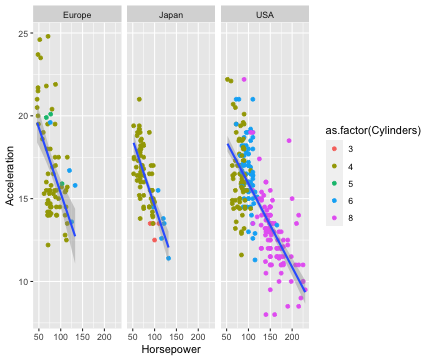

RObject{VecSxp}


┌ Warning: RCall.jl: `geom_smooth()` using formula 'y ~ x'
│ Warning: Removed 6 rows containing non-finite values (stat_smooth).
│ Warning: Removed 6 rows containing missing values (geom_point).
└ @ RCall /Users/ppalmes/.julia/packages/RCall/6kphM/src/io.jl:172


In [18]:
R"""
library(ggplot2)

ggplot(rcars,aes(Horsepower,Acceleration)) +
   geom_point(aes(color=as.factor(Cylinders))) + 
   stat_smooth(method='lm')+
   facet_wrap( ~ Origin) 
"""

In [19]:
R"names(rcars)"

RObject{StrSxp}
[1] "Name"             "Miles_per_Gallon" "Cylinders"        "Displacement"    
[5] "Horsepower"       "Weight_in_lbs"    "Acceleration"     "Year"            
[9] "Origin"          


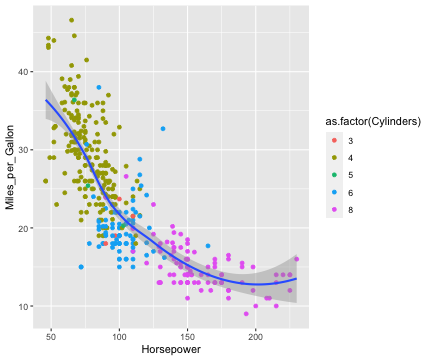

RObject{VecSxp}


┌ Warning: RCall.jl: `geom_smooth()` using method = 'loess' and formula 'y ~ x'
│ Warning: Removed 14 rows containing non-finite values (stat_smooth).
│ Warning: Removed 14 rows containing missing values (geom_point).
└ @ RCall /Users/ppalmes/.julia/packages/RCall/6kphM/src/io.jl:172


In [20]:
R"""
library(ggplot2)

ggplot(rcars,aes(Horsepower,Miles_per_Gallon)) +
   geom_point(aes(color=as.factor(Cylinders))) +
   stat_smooth(method='auto')
"""

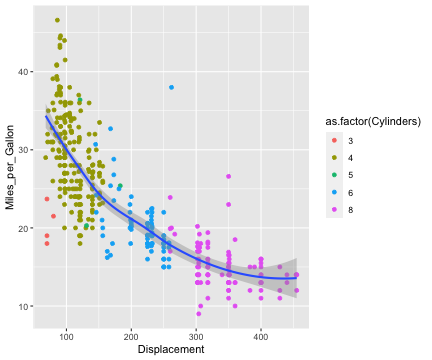

RObject{VecSxp}


┌ Warning: RCall.jl: `geom_smooth()` using method = 'loess' and formula 'y ~ x'
│ Warning: Removed 8 rows containing non-finite values (stat_smooth).
│ Warning: Removed 8 rows containing missing values (geom_point).
└ @ RCall /Users/ppalmes/.julia/packages/RCall/6kphM/src/io.jl:172


In [21]:
R"""
library(ggplot2)

ggplot(rcars,aes(Displacement,Miles_per_Gallon)) +
   geom_point(aes(color=as.factor(Cylinders))) + 
   stat_smooth()
"""

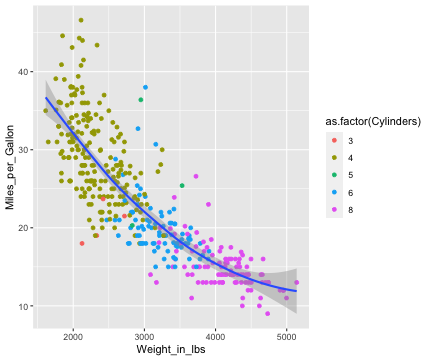

RObject{VecSxp}


┌ Warning: RCall.jl: `geom_smooth()` using method = 'loess' and formula 'y ~ x'
│ Warning: Removed 8 rows containing non-finite values (stat_smooth).
│ Warning: Removed 8 rows containing missing values (geom_point).
└ @ RCall /Users/ppalmes/.julia/packages/RCall/6kphM/src/io.jl:172


In [22]:
R"""
library(ggplot2)

ggplot(rcars,aes(Weight_in_lbs,Miles_per_Gallon)) +
   geom_point(aes(color=as.factor(Cylinders))) +
   stat_smooth()
"""

In [23]:
sort(cars,:Acceleration) |> top5

,Name,Miles_per_Gallon,Cylinders,Displacement,Horsepower,Weight_in_lbs,Acceleration,Year,Origin
,String,Float64?,Int64,Float64,Int64?,Int64,Float64,String,String
1,plymouth 'cuda 340,14.0,8,340.0,160,3609,8.0,1970-01-01,USA
2,ford mustang boss 302,missing,8,302.0,140,3353,8.0,1970-01-01,USA
3,plymouth fury iii,14.0,8,440.0,215,4312,8.5,1970-01-01,USA
4,amc ambassador dpl,15.0,8,390.0,190,3850,8.5,1970-01-01,USA
5,chevrolet impala,14.0,8,454.0,220,4354,9.0,1970-01-01,USA


In [24]:
R"""
library(randomForest)

ccars=rcars[complete.cases(rcars),]

rf_model = randomForest(Miles_per_Gallon ~ Cylinders + Displacement + 
                     Horsepower + Acceleration + Weight_in_lbs, data=ccars)
"""

┌ Warning: RCall.jl: randomForest 4.6-14
│ Type rfNews() to see new features/changes/bug fixes.
│ 
│ Attaching package: ‘randomForest’
│ 
│ The following object is masked from ‘package:dplyr’:
│ 
│     combine
│ 
│ The following object is masked from ‘package:ggplot2’:
│ 
│     margin
│ 
└ @ RCall /Users/ppalmes/.julia/packages/RCall/6kphM/src/io.jl:172


RObject{VecSxp}

Call:
 randomForest(formula = Miles_per_Gallon ~ Cylinders + Displacement +      Horsepower + Acceleration + Weight_in_lbs, data = ccars) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 1

          Mean of squared residuals: 13.87379
                    % Var explained: 77.17


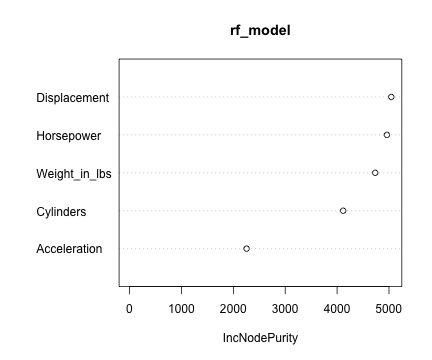

RObject{RealSxp}
              IncNodePurity
Cylinders          4117.176
Displacement       5044.659
Horsepower         4960.480
Acceleration       2255.485
Weight_in_lbs      4735.287


In [25]:
R"varImpPlot(rf_model)"

In [26]:
R"""

ccars=rcars[complete.cases(rcars),]

lm_model = lm(Miles_per_Gallon ~ Cylinders + Displacement + 
              Horsepower + Acceleration + Weight_in_lbs, data=ccars)
"""

RObject{VecSxp}

Call:
lm(formula = Miles_per_Gallon ~ Cylinders + Displacement + Horsepower + 
    Acceleration + Weight_in_lbs, data = ccars)

Coefficients:
  (Intercept)      Cylinders   Displacement     Horsepower   Acceleration  
    4.626e+01     -3.979e-01     -8.313e-05     -4.526e-02     -2.910e-02  
Weight_in_lbs  
   -5.187e-03  



In [27]:
R"summary(lm_model)"

RObject{VecSxp}

Call:
lm(formula = Miles_per_Gallon ~ Cylinders + Displacement + Horsepower + 
    Acceleration + Weight_in_lbs, data = ccars)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.5816  -2.8618  -0.3404   2.2438  16.3416 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    4.626e+01  2.669e+00  17.331   <2e-16 ***
Cylinders     -3.979e-01  4.105e-01  -0.969   0.3330    
Displacement  -8.313e-05  9.072e-03  -0.009   0.9927    
Horsepower    -4.526e-02  1.666e-02  -2.716   0.0069 ** 
Acceleration  -2.910e-02  1.258e-01  -0.231   0.8171    
Weight_in_lbs -5.187e-03  8.167e-04  -6.351    6e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.247 on 386 degrees of freedom
Multiple R-squared:  0.7077,	Adjusted R-squared:  0.7039 
F-statistic: 186.9 on 5 and 386 DF,  p-value: < 2.2e-16



In [28]:
R"""
library(caret)

ccars=rcars[complete.cases(rcars),]

crt_model = train(Miles_per_Gallon ~ Cylinders + Displacement + 
                     Horsepower + Acceleration + Weight_in_lbs, data=ccars,method='rf')
"""

┌ Warning: RCall.jl: Loading required package: lattice
│ 
│ Attaching package: ‘caret’
│ 
│ The following object is masked from ‘package:purrr’:
│ 
│     lift
│ 
└ @ RCall /Users/ppalmes/.julia/packages/RCall/6kphM/src/io.jl:172


RObject{VecSxp}
Random Forest 

392 samples
  5 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 392, 392, 392, 392, 392, 392, ... 
Resampling results across tuning parameters:

  mtry  RMSE      Rsquared   MAE     
  2     3.862706  0.7604945  2.768068
  3     3.917217  0.7541453  2.804791
  5     3.999411  0.7444203  2.863749

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 2.


In [29]:
R"crt_model$finalModel"

RObject{VecSxp}

Call:
 randomForest(x = x, y = y, mtry = param$mtry) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 2

          Mean of squared residuals: 13.32031
                    % Var explained: 78.08


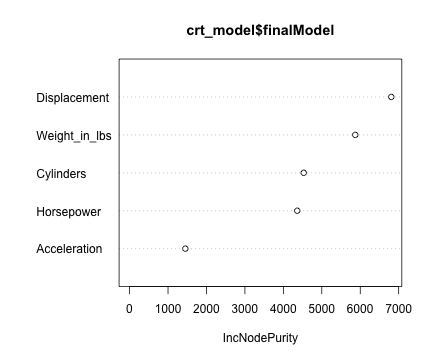

RObject{RealSxp}
              IncNodePurity
Cylinders          4529.651
Displacement       6807.619
Horsepower         4361.078
Acceleration       1450.113
Weight_in_lbs      5870.594


In [30]:
R"varImpPlot(crt_model$finalModel)"